# TM10007 Final version of notebook
This notebook consists of 2 parts:
1. Experimental setup
2. Model optimization

Both parts include data loading and preprocessing to make sure the models are trained on the right (splitted) dataset.

## Part 1: Experimental setup

### Import modules

In [42]:
# Import data module
from adni.load_data import load_data

# Import needed modules
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### Data loading

In [43]:
# Data loading 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
df= pd.DataFrame(data)

# Reset index, add patient ID's as column
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'ID'})

# Set AD to 1, CN to 0
df['label']= df['label'].replace(['AD'],1) 
df['label']= df['label'].replace(['CN'],0) 

The number of samples: 855
The number of columns: 268


### Data cleaning

In [45]:
# Check whether there is missing data (NaN)
df.notnull().values.any() # No missing data

# If SD 0, remove feature
df_new = df.drop(df.std()[df.std() == 0].index.values, axis = 1)

print(f'The number of samples after cleaning + std: {len(df_new.index)}')
print(f'The number of columns after cleaning + std: {len(df_new.columns)}')

# Count number of duplicated patient IDs
df_new.index.duplicated().sum() # IDs are indices in df
X = df_new.drop('ID', axis=1) # Drop patient ID

The number of samples after cleaning + std: 855
The number of columns after cleaning + std: 262


/var/folders/wt/6j07594j3bs65w_hh8gnyk4r0000gn/T/ipykernel_31819/2340064397.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_new = df.drop(df.std()[df.std() == 0].index.values, axis = 1)


### Data split (test, train, validation)

In [46]:
# Test / Train split: stratified on label 
y = df_new['label'] # Define label y (output)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = X['label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = X_train['label'])

# Drop labels
X_train = X_train.drop('label', axis=1)
X_val = X_val.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)
X = X.drop('label', axis=1)

### Data exploration

##### Check for outliers

In [47]:
print(X_train.skew()) # Skewness function to check for outliers
X_train.describe()

hf_energy                                             2.125061
hf_entropy                                            0.232734
hf_kurtosis                                           0.046587
hf_max                                                0.552190
hf_mean                                               0.071600
                                                        ...   
vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0              3.717969
vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0    0.000000
vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0             0.000000
vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0          0.923776
vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0               0.000000
Length: 260, dtype: float64


,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,...,"vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,...,512.000000,5.120000e+02,5.120000e+02,5.120000e+02,5.120000e+02,512.000000,5.120000e+02,5.120000e+02,512.000000,5.120000e+02
mean,3271.381284,4.724196,1.780715,1.818264,1.143216,1.221841,0.084359,301.105469,0.505675,1.733905,...,1.725698,1.251591e-09,4.548393e-10,3.711917e-10,1.067539e-10,15.855469,3.758758e-10,1.144837e-09,1.111667,3.234715e-10
std,3003.312749,0.318636,1.875766,0.287430,0.307507,0.299325,0.421483,98.510058,0.292513,0.381104,...,5.189503,9.995464e-10,3.909179e-10,3.724864e-10,1.907151e-10,24.710587,3.438797e-10,9.613209e-10,1.028020,2.615270e-10
min,311.265383,3.956519,-1.551065,1.115581,0.172529,0.059445,-0.662025,67.000000,0.205472,0.790367,...,-3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,-1.395524,0.000000e+00
25%,1372.511846,4.468442,0.222499,1.616381,0.956384,1.052361,-0.253865,220.750000,0.309537,1.451610,...,-0.978749,6.295804e-10,1.951146e-10,1.060938e-10,2.501304e-24,2.000000,1.489309e-10,4.927426e-10,0.315681,1.571144e-10
50%,2224.064666,4.685806,1.989390,1.815432,1.146903,1.217793,0.023583,308.500000,0.376930,1.735280,...,0.484864,1.025343e-09,3.742419e-10,2.835683e-10,1.314143e-11,7.000000,3.132413e-10,9.220202e-10,1.010562,2.741061e-10
75%,3881.470775,4.979203,3.119404,1.999473,1.329555,1.387473,0.374911,368.000000,0.572249,1.990521,...,2.704303,1.654182e-09,6.154888e-10,5.196713e-10,1.387242e-10,17.250000,4.912942e-10,1.571439e-09,1.671424,4.339686e-10
max,18554.633717,5.393750,8.237613,3.415949,2.131128,2.141425,1.373523,636.000000,1.487565,3.372784,...,64.852716,7.809617e-09,3.071739e-09,2.844013e-09,1.641528e-09,227.000000,2.751437e-09,7.122538e-09,6.723008,1.946941e-09


##### PCA visualisation

<Figure size 432x288 with 0 Axes>

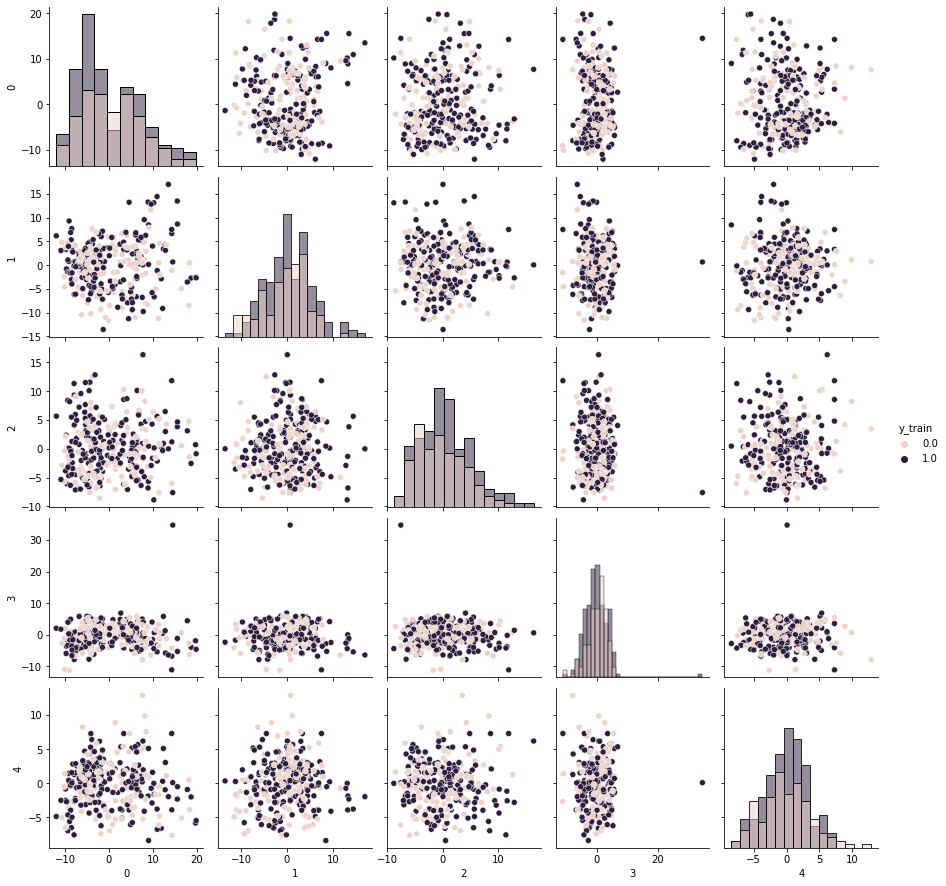

In [48]:
components = 5

# scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train PCA on components
pca = PCA(components)
# fit components to data
pca.fit(X_train_scaled)
# transform train data and apply dimensionality reduction
X_train_trans_pca = pca.transform(X_train_scaled)
X_test_trans_pca = pca.transform(X_test_scaled)

df_train_trans_pca = pd.DataFrame(X_train_trans_pca)
df_y_train = pd.DataFrame({'y_train': y_train})

data_train_pca = df_train_trans_pca.join(df_y_train)

# Plot first 4 principal components
plt.figure()
sb.pairplot(data_train_pca, hue='y_train', diag_kind='hist')


##### tSNE visualisation

<class 'numpy.ndarray'>


<Figure size 432x288 with 0 Axes>

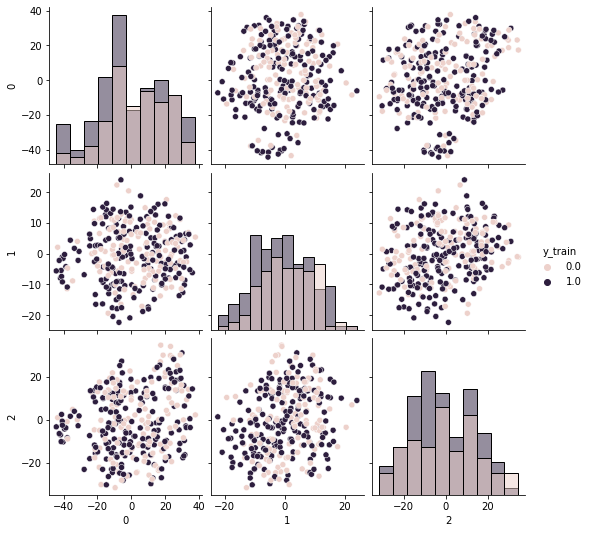

In [49]:
# scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_trans_tsne = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X_train_scaled)
print(type(X_train_trans_tsne))

df_X_train_trans_tsne = pd.DataFrame(X_train_trans_tsne)
df_y_train = pd.DataFrame({'y_train': y_train})
data_train_tsne = df_X_train_trans_tsne.join(df_y_train)
 
plt.figure()
sb.pairplot(data_train_tsne, hue='y_train', diag_kind='hist')

##### LDA visualisation

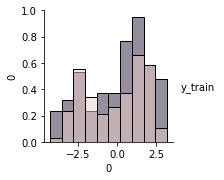

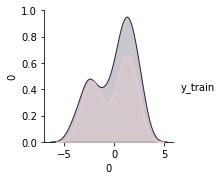

In [50]:
# scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lda = LDA(n_components=1)
X_train_trans_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_trans_lda = lda.transform(X_test_scaled)

df_train_trans_lda = pd.DataFrame(X_train_trans_lda)
df_y_train = pd.DataFrame({'y_train': y_train})

data_train_lda = df_train_trans_lda.join(df_y_train)

sb.pairplot(data_train_lda, hue='y_train',  diag_kind='hist')
sb.pairplot(data_train_lda, hue='y_train')

### Pipeline PCA + KNN

1. StandardScaler
2. Feature extraction: PCA
3. Classifier: KNN 

In [9]:
# Define steps in pipeline
pca = PCA()
knn = KNeighborsClassifier()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])

# Define parameters for gridsearch: depending on which classifier
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('knn', knn)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameter (CV score=0.779):
{'pca__n_components': 15}
0.7286821705426356
0.9102564102564102
0.7171717171717171
0.6806184012066364


### Pipeline LDA + KNN

1. StandardScaler
2. Feature extraction: LDA
3. Classifier: KNN 

In [10]:
# Define steps in pipeline
lda = LDA()
knn = KNeighborsClassifier() 
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('lda', lda), ('knn', knn)])

# Fit pipe_after_grid on data
bst = pipe.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

0.689922480620155
0.782051282051282
0.7261904761904762
0.6655354449472097


### Pipeline kernel-PCA + KNN

1. StandardScaler
2. Feature extraction: kernel-PCA
3. Classifier: KNN 

In [11]:
# Define steps in pipeline
kpca = KernelPCA()
knn = KNeighborsClassifier()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('kpca', kpca), ('knn', knn)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "kpca__n_components": [5, 15, 30, 45, 60],
    "kpca__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 
print(search._get_param_names)
pipe_after_grid = Pipeline([('scaler', scaler), ('kpca', KernelPCA((best_params['kpca__n_components']))), ('knn', knn)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

Best parameter (CV score=0.803):
{'kpca__n_components': 15, 'kpca__kernel': 'cosine'}
<bound method BaseEstimator._get_param_names of <class 'sklearn.model_selection._search.RandomizedSearchCV'>>
0.7286821705426356
0.9102564102564102
0.7171717171717171
0.6806184012066364


### Pipeline PCA + RF

1. StandardScaler
2. Feature extraction: PCA
3. Classifier: RF 

In [12]:
# Define steps in pipeline
scaler = StandardScaler()
pca = PCA()
rf = RandomForestClassifier()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('rf', rf)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('rf', rf)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameter (CV score=0.812):
{'pca__n_components': 45}
0.7829457364341085
0.9102564102564102
0.7717391304347826
0.7492458521870287


### Pipeline LDA + RF

1. StandardScaler
2. Feature extraction: LDA
3. Classifier: RF

In [13]:
# Define steps in pipeline
lda = LDA()
rf = RandomForestClassifier()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('lda', lda), ('rf', rf)])

# Fit pipe_after_grid on data
bst = pipe.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

0.689922480620155
0.7435897435897436
0.7435897435897436
0.6757164404223228


### Pipeline kernel-PCA + RF

1. StandardScaler
2. Feature extraction: kernel-PCA
3. Classifier: RF 

In [14]:
# Define steps in pipeline
kpca = KernelPCA()
rf = RandomForestClassifier()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('kpca', kpca), ('rf', rf)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "kpca__n_components": [5, 15, 30, 45, 60],
    "kpca__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 
print(search._get_param_names)
pipe_after_grid = Pipeline([('scaler', scaler), ('kpca', KernelPCA((best_params['kpca__n_components']))), ('rf', rf)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

Best parameter (CV score=0.814):
{'kpca__n_components': 45, 'kpca__kernel': 'linear'}
<bound method BaseEstimator._get_param_names of <class 'sklearn.model_selection._search.RandomizedSearchCV'>>
0.7596899224806202
0.8846153846153846
0.7582417582417582
0.7266214177978884


### Pipeline PCA + NB

1. StandardScaler
2. Feature extraction: PCA
3. Classifier: NB 

In [15]:
# Define steps in pipeline
pca = PCA()
gnb = GaussianNB()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('gnb', gnb)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('gnb', gnb)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameter (CV score=0.805):
{'pca__n_components': 5}
0.751937984496124
0.9102564102564102
0.7395833333333334
0.7100301659125188


### Pipeline LDA + NB

1. StandardScaler
2. Feature extraction: LDA
3. Classifier: NB 

In [16]:
# Define steps in pipeline
lda = LDA()
gnb = GaussianNB()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('lda', lda), ('gnb', gnb)])

# Fit pipe_after_grid on data
bst = pipe.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

0.6821705426356589
0.7564102564102564
0.7283950617283951
0.6625188536953243


### Pipeline kernel-PCA + NB

1. StandardScaler
2. Feature extraction: kernel-PCA
3. Classifier: NB 

In [17]:
# Define steps in pipeline
kpca = KernelPCA()
gnb = GaussianNB()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('kpca', kpca), ('gnb', gnb)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "kpca__n_components": [5, 15, 30, 45, 60],
    "kpca__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 
print(search._get_param_names)
pipe_after_grid = Pipeline([('scaler', scaler), ('kpca', KernelPCA((best_params['kpca__n_components']))), ('gnb', gnb)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

Best parameter (CV score=0.810):
{'kpca__n_components': 30, 'kpca__kernel': 'cosine'}
<bound method BaseEstimator._get_param_names of <class 'sklearn.model_selection._search.RandomizedSearchCV'>>
0.6976744186046512
0.8717948717948718
0.7010309278350515
0.6515837104072398


### Pipeline PCA + SVM

1. StandardScaler
2. Feature extraction: PCA
3. Classifier: SVM 

In [18]:
# Define steps in pipeline
pca = PCA()
svc = SVC()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('svc', svc)])

# Define parameters for randomized search: depending on which classifier
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    
}
# Perform Randomized Search on pipe
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('svc', svc)])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

Best parameter (CV score=0.826):
{'pca__n_components': 45}
0.7829457364341085
0.8974358974358975
0.7777777777777778
0.7526395173453998


### Pipeline LDA + SVM

1. StandardScaler
2. Feature extraction: LDA
3. Classifier: SVM 

In [19]:
# Define steps in pipeline
lda = LDA()
svc = SVC()
scaler = StandardScaler()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('lda', lda), ('svc', svc)])

# Fit pipe_after_grid on data
bst = pipe.fit(X_train, y_train)

#TEST PERFORMANCE
y_pred = bst.predict(X_val)
y_val = (np.array(y_val))

print(bst.score(X_val, y_val))
print(recall_score(y_val, y_pred))
print(precision_score(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))

0.689922480620155
0.782051282051282
0.7261904761904762
0.6655354449472097


## Part 2: Model optimization

### Import modules

In [59]:
# Import data module
from adni.load_data import load_data
# Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

### Data loading

In [60]:
# Data loading 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
df = pd.DataFrame(data)

# Reset index, add patient ID's as column
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'ID'})

The number of samples: 855
The number of columns: 268


### Data cleaning

In [62]:
# Check whether there is missing data (NaN)
df.notnull().values.any() # No missing data

# If SD 0, remove feature
df_new = df.drop(df.std()[df.std() == 0].index.values, axis = 1)

print(f'The number of samples after cleaning + std: {len(df_new.index)}')
print(f'The number of columns after cleaning + std: {len(df_new.columns)}')

# Count number of patients labeled with AD or CN
df_ad = df_new[df_new['label']=='AD']
df_cn = df_new[df_new['label']=='CN']
print(len(df_ad))
print(len(df_cn))

df_new['label']= df_new['label'].replace(['AD'],1) 
df_new['label']= df_new['label'].replace(['CN'],0) 

# Count number of duplicated patiient IDs
df_new.index.duplicated().sum() # IDs are indices in df
X = df_new.drop('ID', axis=1) # Drop patient ID

The number of samples after cleaning + std: 855
The number of columns after cleaning + std: 262
519
336


/var/folders/wt/6j07594j3bs65w_hh8gnyk4r0000gn/T/ipykernel_31819/3887852866.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_new = df.drop(df.std()[df.std() == 0].index.values, axis = 1)


### Data split (test, train, validation)

In [63]:
# Test / Train split: stratified on label
y = df_new['label'] # Define label y (output)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, stratify=X['label'], random_state=1)

# Drop labels
X_train = X_train.drop('label', axis=1)
X_test = X_test.drop('label', axis=1)
X = X.drop('label', axis=1)

## Pipeline best scoring model - PCA & RF

1. RobustScaler
2. Feature extraction: PCA
3. Classifier: RF 

In [69]:
# Define steps in pipeline
scaler = RobustScaler() # Because there are outliers in data
pca = PCA()
rf = RandomForestClassifier()

# Create pipeline with steps: scaler, PCA, classifier
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('rf', rf)])

# Define parameters for randomized search
param_grid = {
    "pca__n_components": [int(x) for x in np.linspace(start = 5, stop = 200, num = 5)],
    "rf__n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    "rf__max_depth": [int(x) for x in np.linspace(10, 120, num = 12)],
}
# Perform Randomized Search on pipe
search = RandomizedSearchCV(pipe, param_grid, n_iter = 20, cv = 5, scoring='accuracy', random_state = 1)
search.fit(X_train, y_train)

# Print outcome Randomized Search
print("Best parameter (CV score=%0.3f):" % search.best_score_)
best_params = search.best_params_
print(best_params) 

pipe_after_grid = Pipeline([('scaler', scaler), ('pca', PCA((best_params['pca__n_components']))), ('rf', RandomForestClassifier(n_estimators = (best_params['rf__n_estimators']), max_depth = (best_params['rf__max_depth'])))])

# Fit pipe_after_grid on data
bst = pipe_after_grid.fit(X_train, y_train)

Best parameter (CV score=0.800):
{'rf__n_estimators': 600, 'rf__max_depth': 50, 'pca__n_components': 53}


### Apply model on test set and evaluate performance

0.7757009345794392
0.8360347985347986


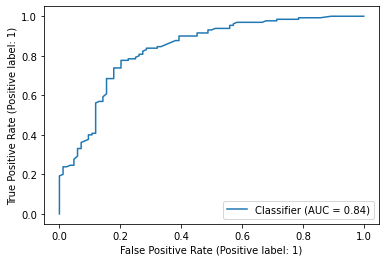

In [70]:
# Apply trained pipe on test set
y_test = (np.array(y_test))
y_pred_plot = bst.predict_proba(X_test)[:, 1]

print(bst.score(X_test, y_test)) # Accuracy
print(roc_auc_score(y_test, y_pred_plot)) # ROC AUC

# Plot ROC-curve 
RocCurveDisplay.from_predictions(y_test, y_pred_plot)

### Final model with hyperparameter values from search 

In [88]:
pipe_final = Pipeline([('scaler', scaler), ('pca', PCA(n_components = 53)), ('rf', RandomForestClassifier(n_estimators = 600, max_depth = 50, random_state = 1))])

# Fit pipe_after_grid on data
bst_final = pipe_final.fit(X_train, y_train)

0.780373831775701
0.8426739926739928


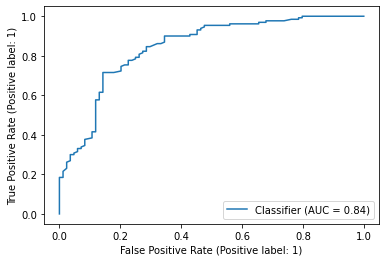

In [89]:
# Apply trained pipe on test set
y_test = (np.array(y_test))
y_pred_plot = bst_final.predict_proba(X_test)[:, 1]

print(bst_final.score(X_test, y_test)) # Accuracy
print(roc_auc_score(y_test, y_pred_plot)) # ROC AUC

# Plot ROC-curve 
RocCurveDisplay.from_predictions(y_test, y_pred_plot)